# EVALUATE RESULTS

### Import relevant packages

In [729]:
import pandas as pd
import os
import copy
import re
import glob
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import precision_recall_fscore_support, f1_score

# plotting + styles
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font="serif", font_scale=1.2)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state ("rs1" to "rs10" for the 10 random seeds, plus "al" for active learning and "full" for models trained on all available training data)

In [301]:
results_dict = dict()

for testset in sorted(os.listdir("./results")):
    print(testset)
    results_dict[testset] = dict()

    for model in sorted(pd.unique(["_".join(m.split("_")[:4]) for m in os.listdir(f"./results/{testset}")])):
        if "ipynb" not in model:
            print("  ", model)
            results_dict[testset][model] = dict()

            for size in sorted(pd.unique([int(i.split("_")[-2]) for i in glob.glob(f"./results/{testset}/{model}*.csv")])):
                if size!=0:
                    results_dict[testset][model][size] = dict()
                    for random_state in sorted(pd.unique([i.split("_")[-1].rstrip(".csv") for i in glob.glob(f"./results/{testset}/{model}*_{size}_*.csv")])):
                        for filename in glob.glob(f"./results/{testset}/{model}*{size}_{random_state}.csv"):
                            results_dict[testset][model][size][random_state] = pd.read_csv(filename)

            # 0-shot xlmt models
            #for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
            #    results_dict[testset][model][0] = dict()
            #    results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)
            #    del results_dict[testset][model][20000]["rs1"] # delete redundant entry

bas19_es_test_2000
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
for19_pt_test_2000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
has21_hi_test_2000
   hibert_hi_has21_hi
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_ar
   arabert_ar_ous19_ar
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_es
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_hi
   hibert_hi_has21_hi
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_it
   umberto_it_san20_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xl

### Compute macro F1 for each model/testset combination

In [302]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
for19_pt_test_2000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
has21_hi_test_2000
  hibert_hi_has21_hi
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_ar
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_hi
  hibert_hi_has21_hi
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_it
  umberto_it_san20_it
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
ous19_ar_test_1000
  a

### Create flat df of results for easier plotting

In [303]:
%%time

metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, int(size), selection_strat, metrics_dict[testset][model][size][selection_strat]]

metrics_df["log_train_size"] = metrics_df.train_size.apply(lambda x: np.log(x))
metrics_df["selection_strat_category"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else ("full" if x=="full" else "random"))

CPU times: user 3.01 s, sys: 60.2 ms, total: 3.07 s
Wall time: 3.07 s


### Validate that no results are missing
Expecting 10 results from 10 different random seeds per testset + model + train_size (n = 12) --> 120 per model

In [304]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model", "train_size"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=10]

,testset,model,train_size,selection_strat


In [305]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=120].sort_values("model")

,testset,model,selection_strat


## Summary Plots
### DETAIL: Average macro F1 across random seeds across models for each testset + MHC

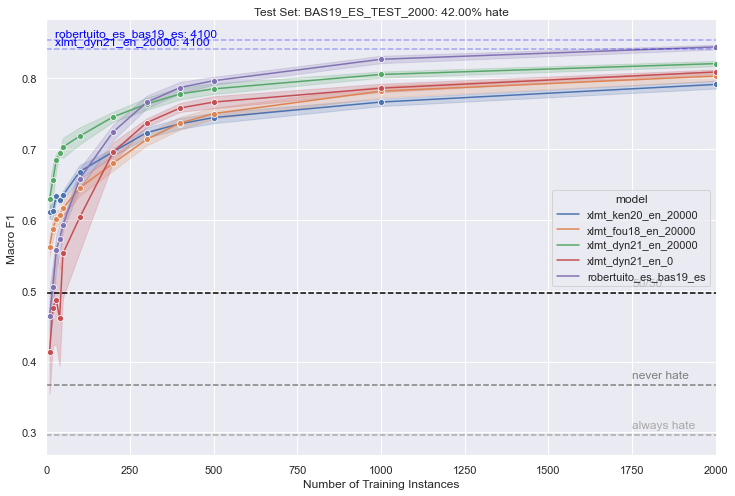

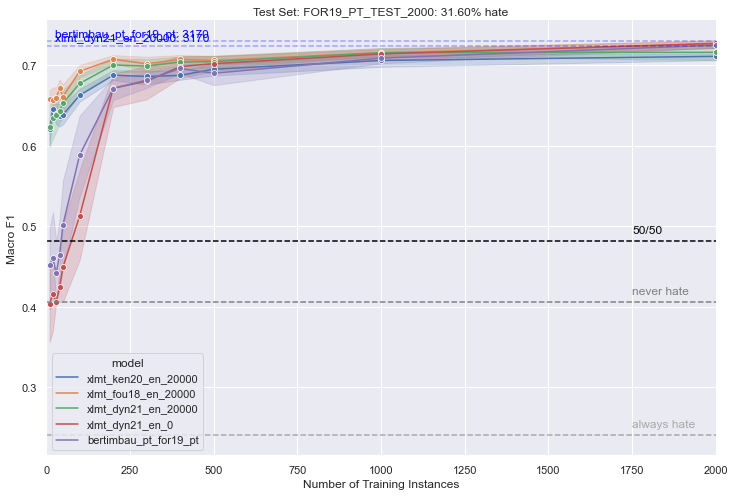

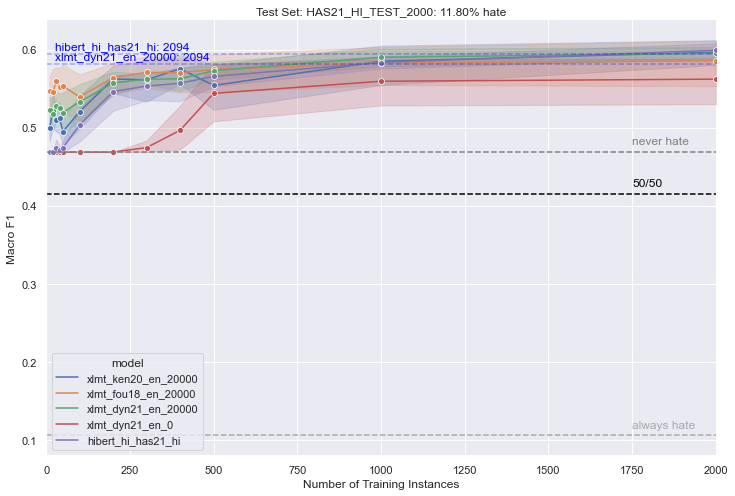

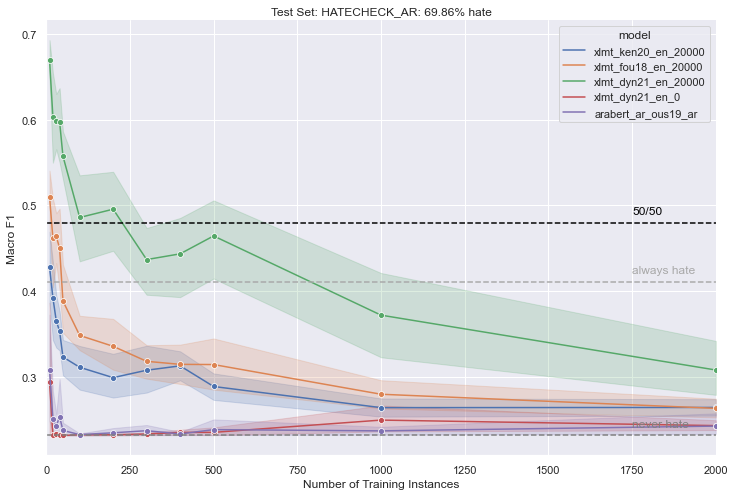

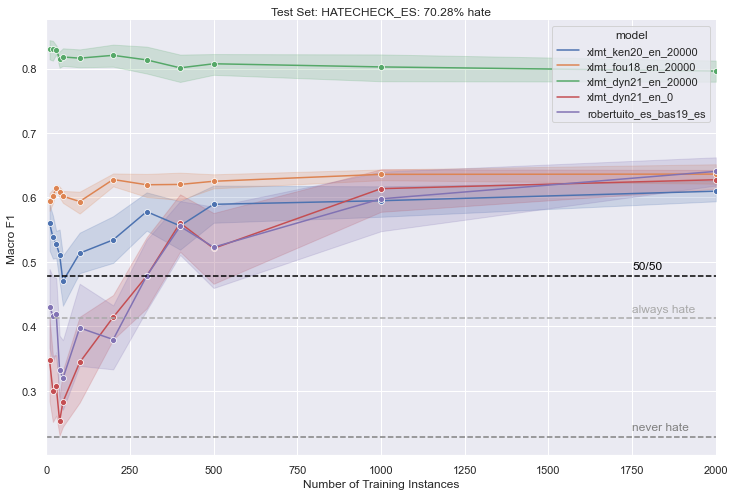

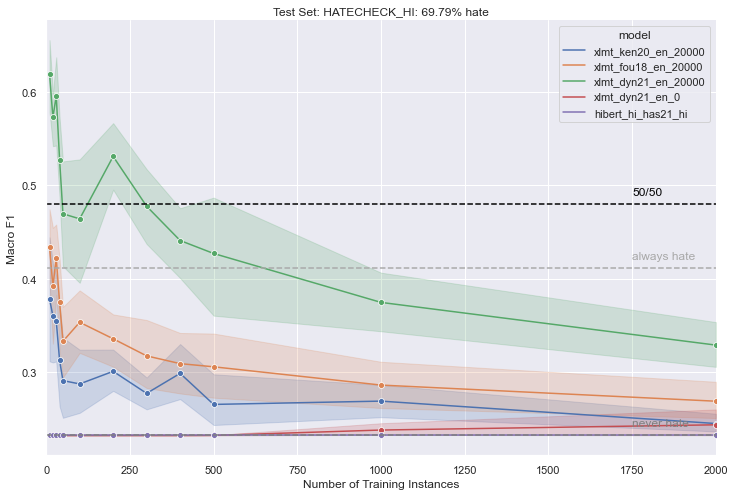

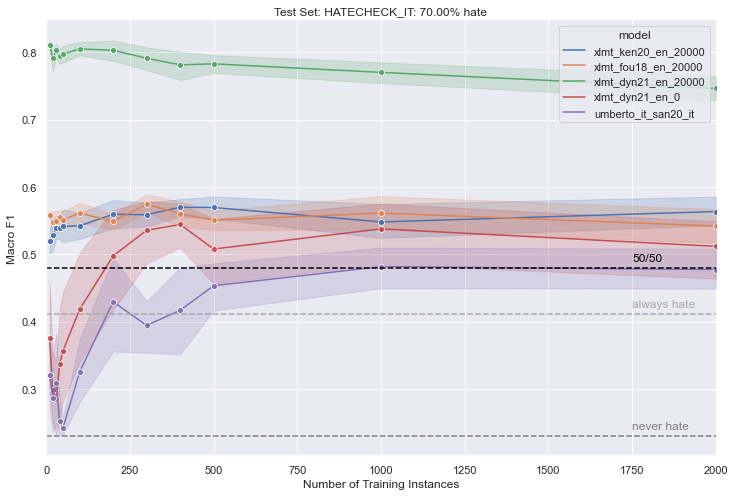

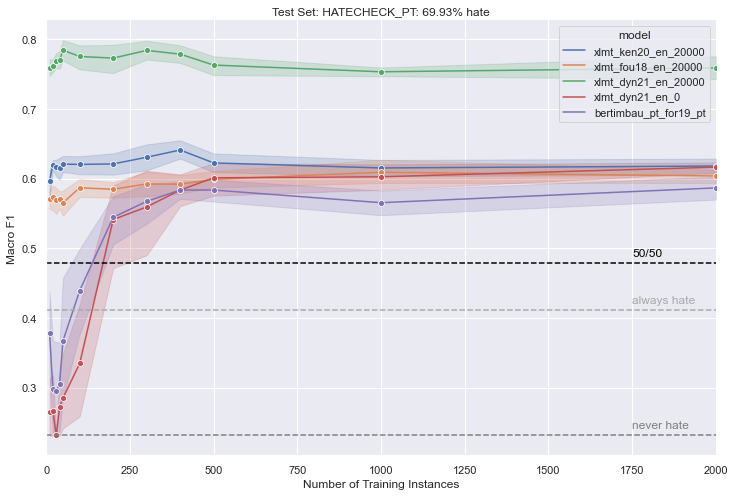

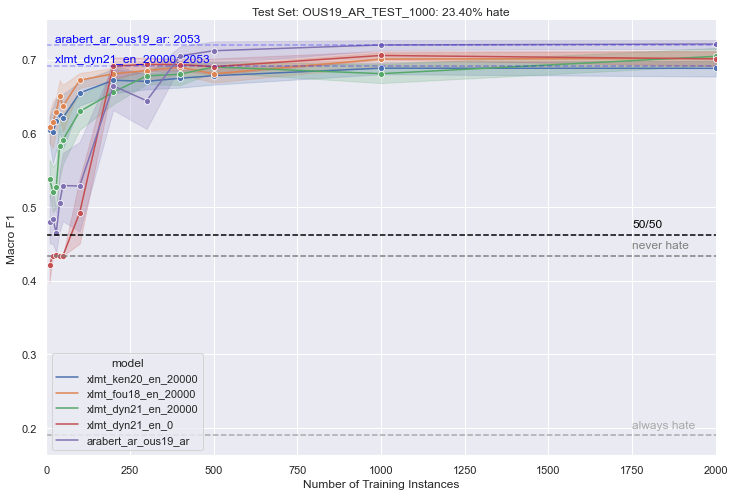

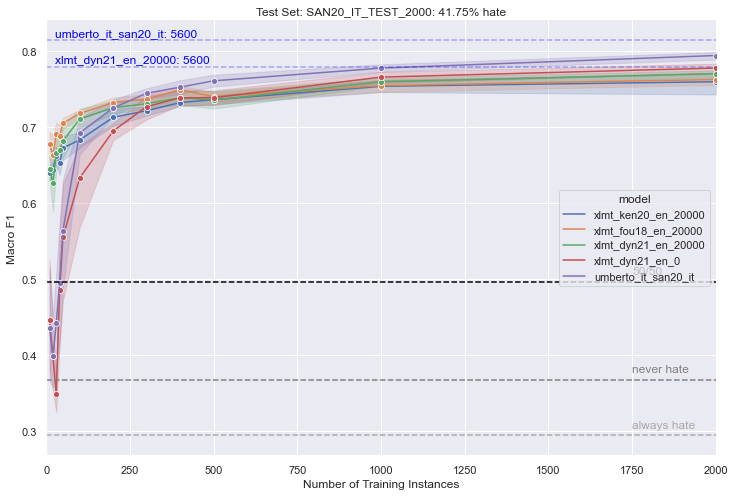

In [306]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

for target_testset in sorted([t for t in metrics_dict.keys()]):

    f = plt.figure(figsize=(12,8))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # Model performance on full data: 
    if RESULTS_ON_FULL_DATA:
        for _, row in metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="full")].sort_values(["model"]).iterrows():
            p.axhline(row.macro_f1, color="blue", linestyle="--", alpha=0.3)
            p.annotate(f"{row.model}: {row.train_size}", xy= (1750,row.macro_f1),  xytext=(25,row.macro_f1+0.005), color = "blue")
    
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        p.axhline(always_hate, color="darkgrey", linestyle="--")
        p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        p.axhline(never_hate, color="grey", linestyle="--")
        p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        p.axhline(equal_prob, color="black", linestyle="--")
        p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.01), color="black")
    
    # Plot formatting
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()

In [878]:
def f1_plot(target_testset, cell, BASELINES, FILTER, xlim=False, ylim=False, legend=True, legend_xy=False,
            xaxis_labels=True, yaxis_labels=True, yaxis_ticks=True, baseline_label=1700):
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    
    # Filter out models that we don't want to show
    for f in FILTER:
        plot_df = plot_df[~plot_df.model.str.contains(f)]
        
    # Map full model names to shorthand:
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "arabert_ar_ous19_ar": "M", "umberto_it_san20_it": "M", "bertimbau_pt_for19_pt": "M", "hibert_hi_has21_hi": "M"}
    plot_df["model"] = plot_df.model.apply(lambda x: model_map[x])
    
    ax = plt.subplot(cell)
    ax = sns.lineplot(ax=ax, x="train_size", y="macro_f1", hue="model", hue_order=sorted(pd.unique(plot_df.model)),
                      data = plot_df, estimator="mean", marker="o", ci=95)
    sns.despine()
    
    # Plot formatting
    if legend_xy!=False:
        ax.legend(title="Model", loc=legend_xy, framealpha=1)
    else:
        ax.legend(title="Model", framealpha=1)

    lss = [':', ':', '-', '-', "-"]
    handles = ax.legend_.legendHandles
    for line, ls, handle in zip(ax.lines, lss, handles):
        line.set_linestyle(ls)
        handle.set_linestyle(ls)
    
    ax.set_title(target_testset.replace("_test_2000", "").replace("_test_1000", "").upper())
    ax.set_xlabel("N")
    ax.set_ylabel("Macro F1")
    
    if xlim:
        ax.set_xlim(xlim)
    
    if ylim:
        ax.set_ylim(ylim)
    
    if not legend:
        ax.get_legend().remove()
        
    if not xaxis_labels:
        ax.set_xlabel("")
        ax.xaxis.set_ticklabels([])
    
    if not yaxis_labels:
        ax.set_ylabel("")
        
    if not yaxis_ticks:
        ax.yaxis.set_ticklabels([])
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        ax.axhline(always_hate, color="darkgrey", linestyle="--")
        ax.annotate('always hate', xy= (baseline_label,always_hate),  xytext=(baseline_label,always_hate+0.01),
                    color = "darkgrey", horizontalalignment="right")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        ax.axhline(never_hate, color="grey", linestyle="--")
        ax.annotate('never hate', xy= (baseline_label,never_hate),  xytext=(baseline_label,never_hate+0.01),
                    color="grey", horizontalalignment="right")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        ax.axhline(equal_prob, color="black", linestyle="--")
        ax.annotate('50/50', xy= (baseline_label,equal_prob),  xytext=(baseline_label,equal_prob+0.01),
                    color="black", horizontalalignment="right")


### FIGURE 1: Macro F1 on Held-Out Test Sets

In [816]:
metrics_df[(metrics_df.testset=="hatecheck_it")&(metrics_df.model=="umberto_it_san20_it")&(metrics_df.train_size==200)].macro_f1.mean()

0.4294473559035019

In [817]:
metrics_df[(metrics_df.testset=="hatecheck_it")&(metrics_df.model=="xlmt_fou18_en_20000")&(metrics_df.train_size==20)].macro_f1.mean()

0.5482621077236869

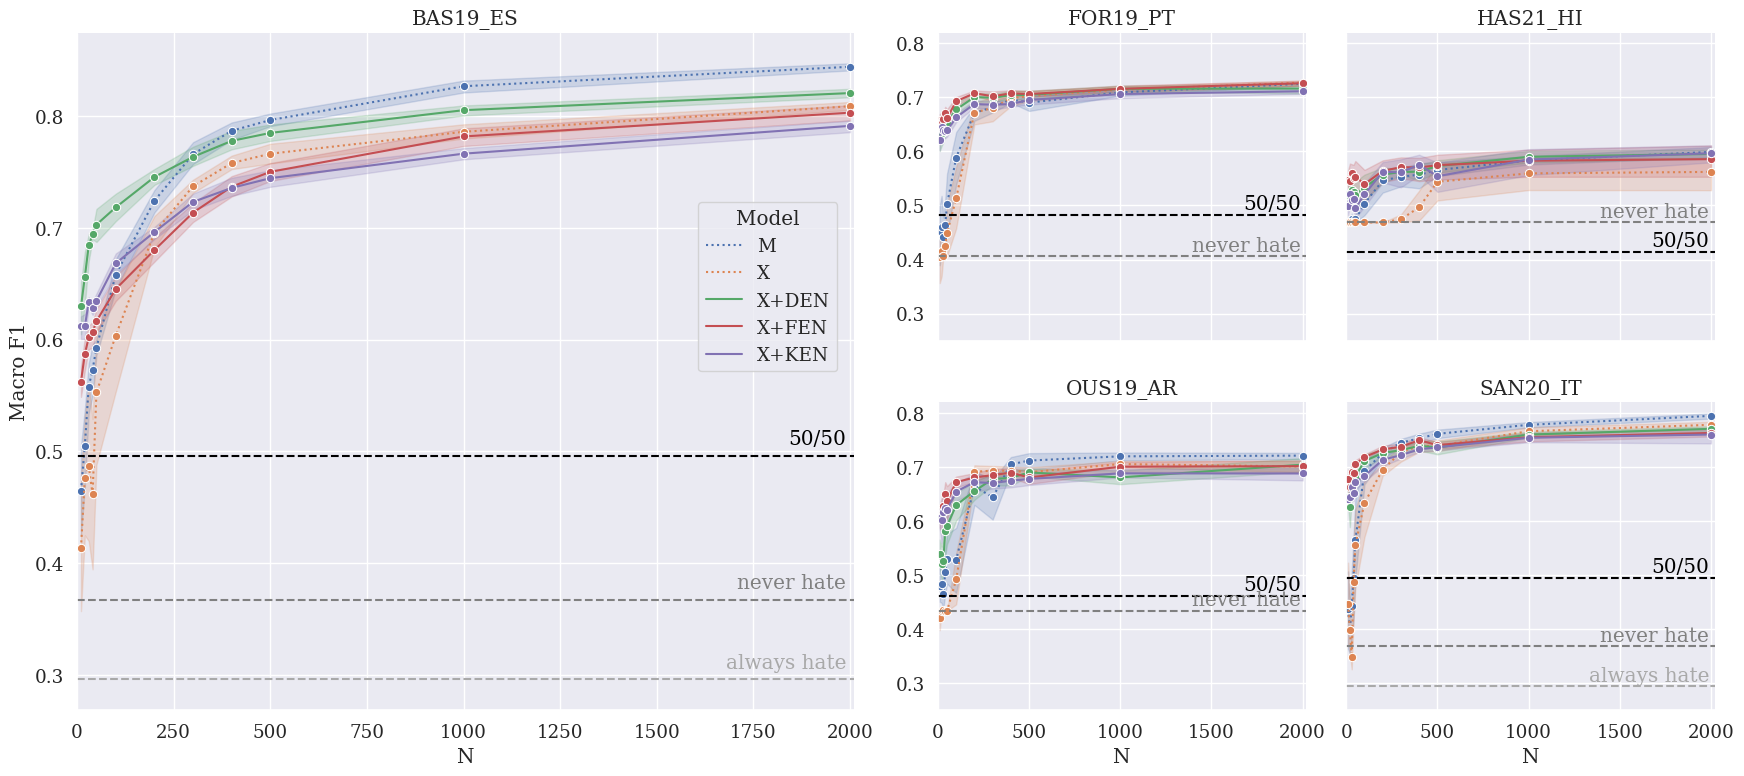

In [827]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(16, 8)) 
gs_full = GridSpec(1, 2, width_ratios=[1, 1]) 
gs_l =  gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_full[0])
gs_r =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_full[1])

# iterate through cells in plot grid

# left side
for target_testset, cell in zip([[t for t in metrics_dict.keys() if not "hatecheck" in t][0]], [c for c in gs_l]):
    f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010), legend=True, legend_xy=(0.8,0.5),
            yaxis_labels=True, baseline_label=1990)

# right side
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t][1:]), [c for c in gs_r]):
    if cell==gs_r[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,0.82), legend=False, xaxis_labels=False, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,0.82), legend=False, xaxis_labels=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)
    if cell==gs_r[2]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,0.82), legend=False, xaxis_labels=True, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[3]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,0.82), legend=False, xaxis_labels=True, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_2000.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

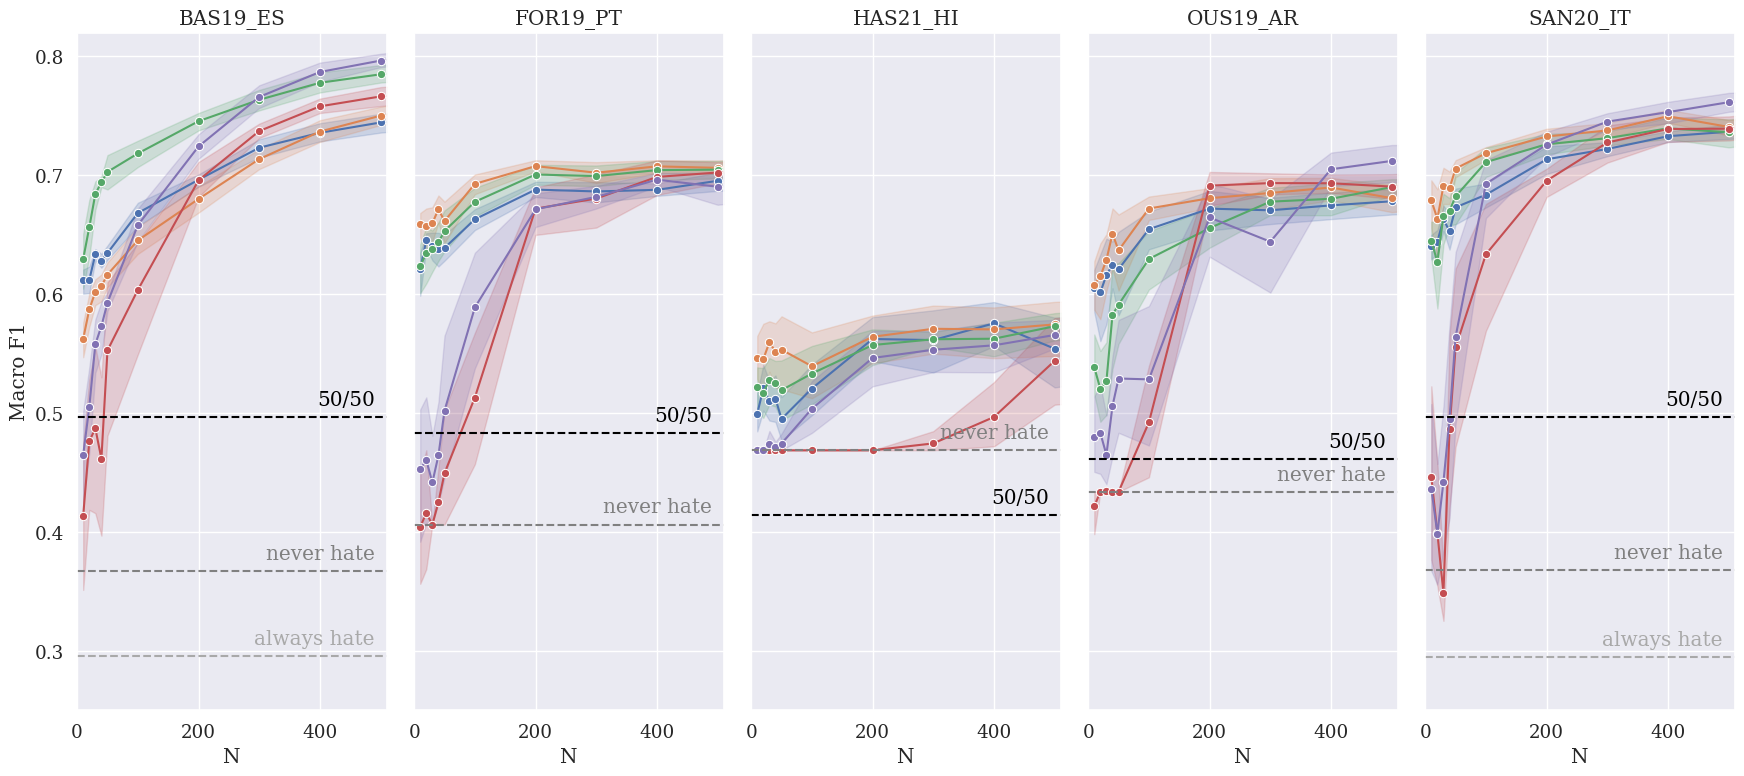

In [677]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(16, 8))
gs_full = GridSpec(1, 5)

# iterate through cells in plot grid
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t]), [c for c in gs_full]):
    if cell!=gs_full[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,510), ylim=(0.25,0.82), legend=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=490)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,510), ylim=(0.25,0.82), legend=False, yaxis_labels=True, baseline_label=490)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_500.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

### TABLE 1: Macro F1 on Held-Out Test Sets

In [851]:
def generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES):

    # Map full model names to shorthand:
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "arabert_ar_ous19_ar": "M", "umberto_it_san20_it": "M", "bertimbau_pt_for19_pt": "M", "hibert_hi_has21_hi": "M"}
    metrics_df["model_shorthand"] = metrics_df.model.apply(lambda x: model_map[x])

    
    for model in MODELS:
        row = model
        for target_testset in TESTSETS:
            for size in TRAIN_SIZES:
                row += " & {:.2f}".format(metrics_df[(metrics_df.testset==target_testset)&(metrics_df.train_size==size)&(metrics_df.model_shorthand==model)].macro_f1.mean())
        row += ' \\' + "\\"
        print(row)
    

In [853]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = [t for t in metrics_dict.keys() if "hatecheck" not in t]
TRAIN_SIZES = [20,200,2000]

generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES)

M & 0.50 & 0.72 & 0.84 & 0.46 & 0.67 & 0.73 & 0.47 & 0.55 & 0.60 & 0.48 & 0.66 & 0.72 & 0.40 & 0.73 & 0.79 \\
X & 0.48 & 0.70 & 0.81 & 0.42 & 0.67 & 0.73 & 0.47 & 0.47 & 0.56 & 0.43 & 0.69 & 0.70 & 0.40 & 0.70 & 0.78 \\
X+DEN & 0.66 & 0.75 & 0.82 & 0.63 & 0.70 & 0.72 & 0.52 & 0.56 & 0.60 & 0.52 & 0.66 & 0.70 & 0.63 & 0.73 & 0.77 \\
X+FEN & 0.59 & 0.68 & 0.80 & 0.66 & 0.71 & 0.73 & 0.55 & 0.56 & 0.59 & 0.61 & 0.68 & 0.70 & 0.66 & 0.73 & 0.76 \\
X+KEN & 0.61 & 0.70 & 0.79 & 0.65 & 0.69 & 0.71 & 0.52 & 0.56 & 0.60 & 0.60 & 0.67 & 0.69 & 0.64 & 0.71 & 0.76 \\


### APPENDIX: Macro F1 on Held-Out Test Sets

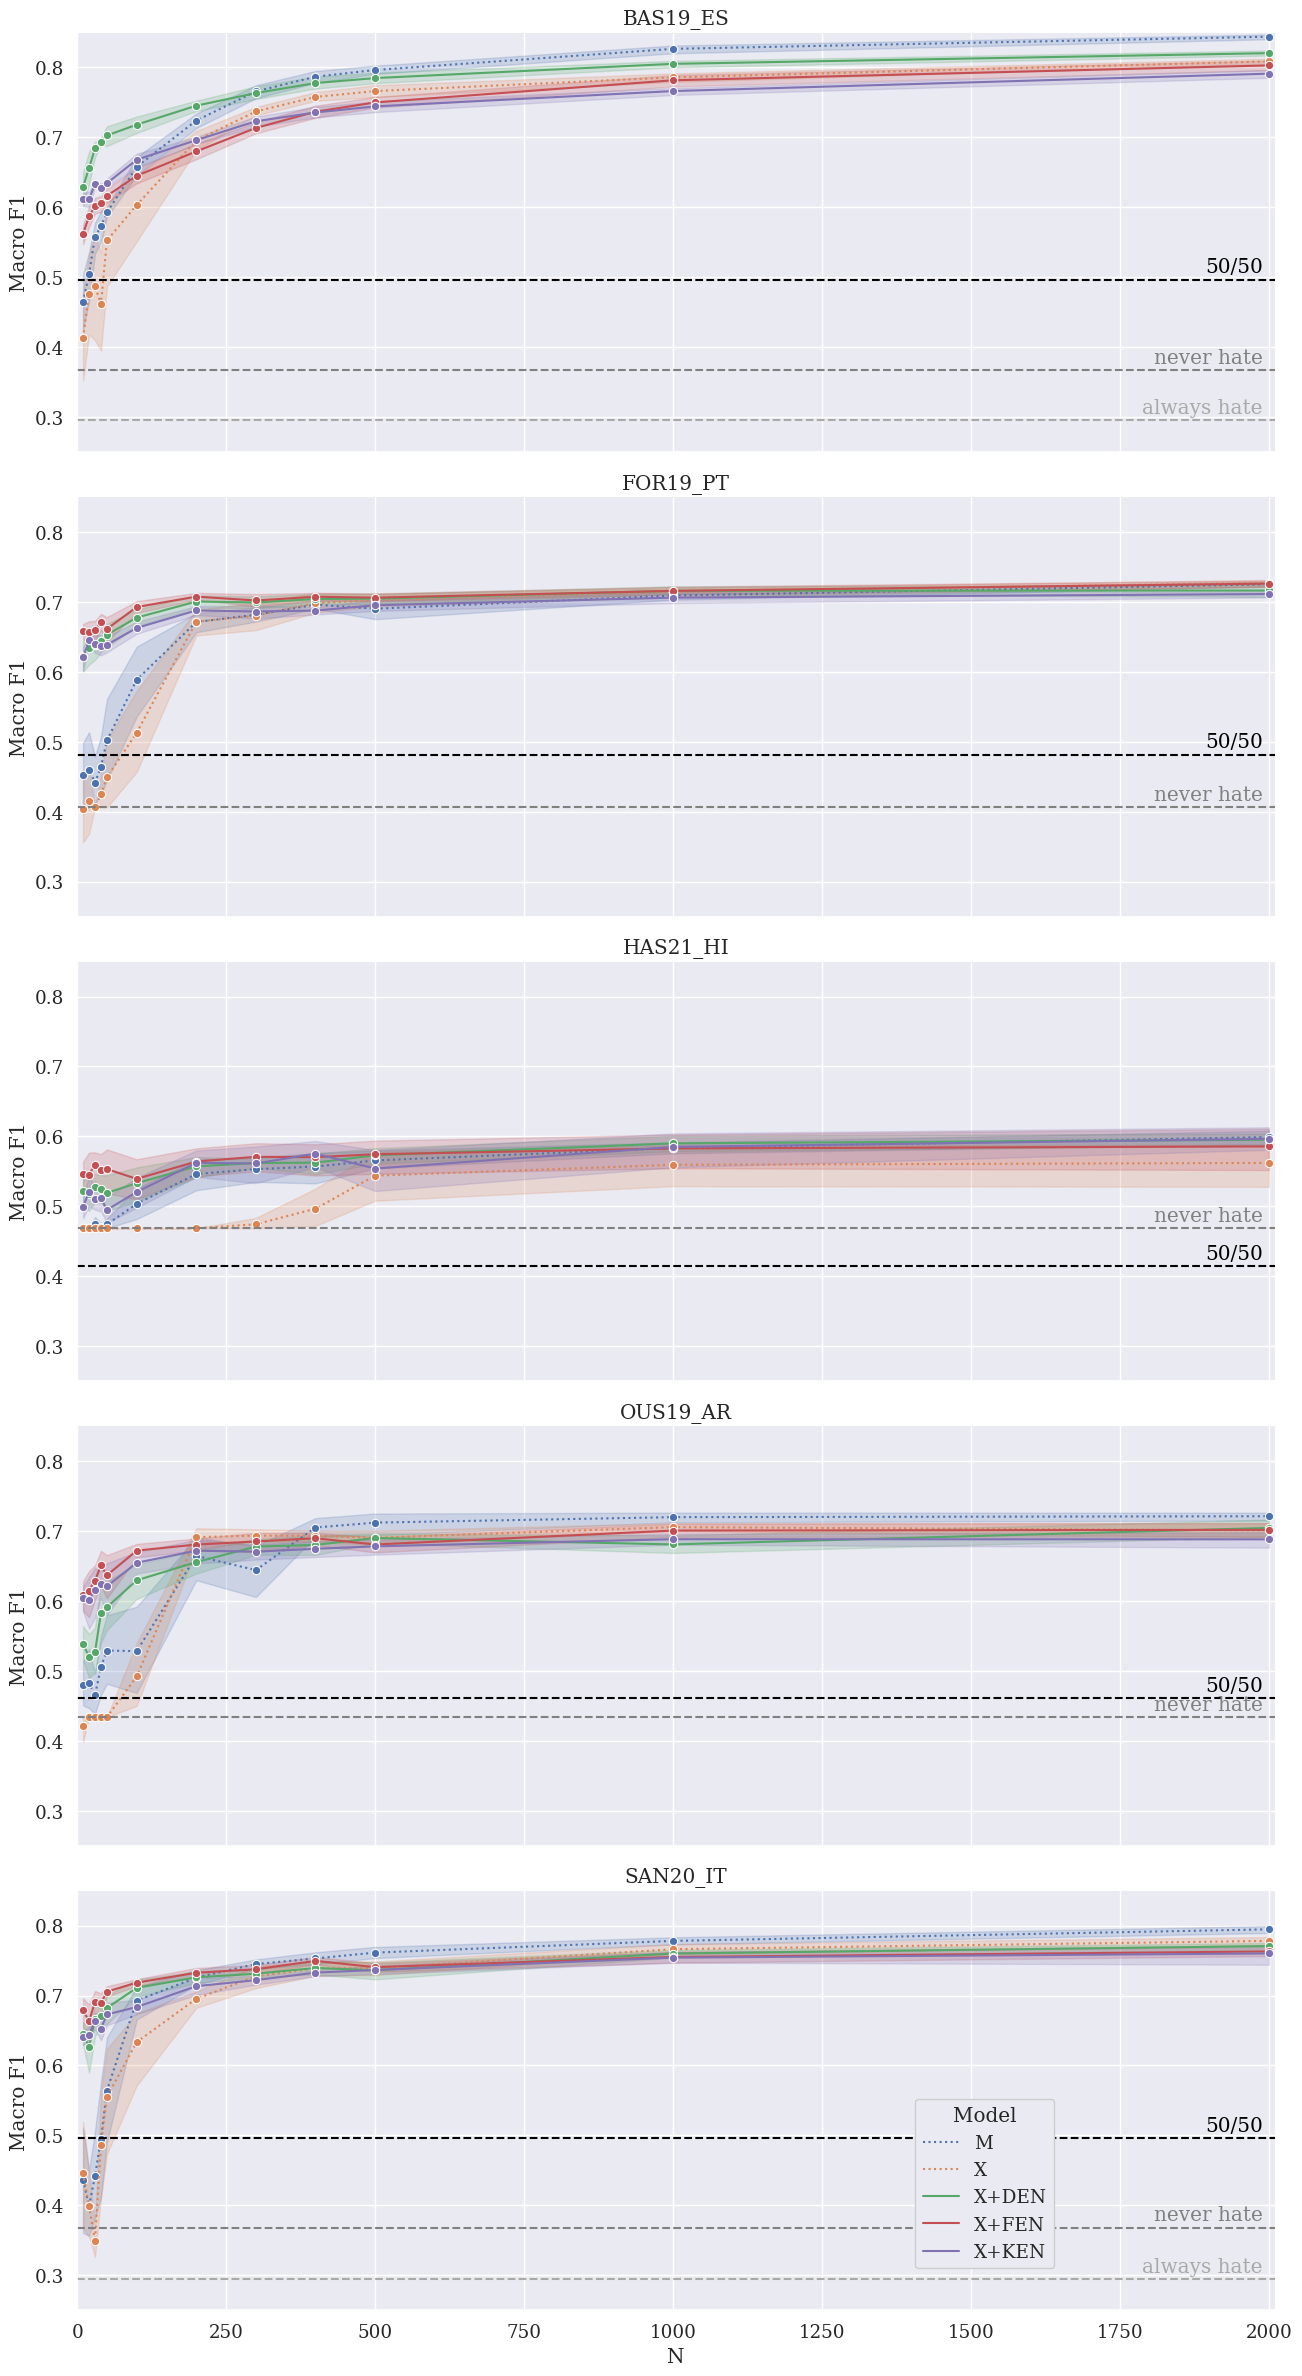

In [879]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(12, 24))
gs_full = GridSpec(5, 1)

# iterate through cells in plot grid
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t]), [c for c in gs_full]):
    if cell!=gs_full[-1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.25,0.85), legend=False, xaxis_labels=False,
            yaxis_labels=True, baseline_label=1990)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.25,0.85), legend=True, legend_xy=(0.7,0.1),
            yaxis_labels=True, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_fullpage.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [885]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = [t for t in metrics_dict.keys() if "hatecheck" not in t]
TRAIN_SIZES = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

for testset in TESTSETS:
    print(testset)
    generate_latex_table(MODELS, [testset], TRAIN_SIZES)
    print()

bas19_es_test_2000
M & 0.46 & 0.50 & 0.56 & 0.57 & 0.59 & 0.66 & 0.72 & 0.77 & 0.79 & 0.80 & 0.83 & 0.84 \\
X & 0.41 & 0.48 & 0.49 & 0.46 & 0.55 & 0.60 & 0.70 & 0.74 & 0.76 & 0.77 & 0.79 & 0.81 \\
X+DEN & 0.63 & 0.66 & 0.68 & 0.69 & 0.70 & 0.72 & 0.75 & 0.76 & 0.78 & 0.78 & 0.81 & 0.82 \\
X+FEN & 0.56 & 0.59 & 0.60 & 0.61 & 0.62 & 0.65 & 0.68 & 0.71 & 0.74 & 0.75 & 0.78 & 0.80 \\
X+KEN & 0.61 & 0.61 & 0.63 & 0.63 & 0.63 & 0.67 & 0.70 & 0.72 & 0.74 & 0.74 & 0.77 & 0.79 \\

for19_pt_test_2000
M & 0.45 & 0.46 & 0.44 & 0.46 & 0.50 & 0.59 & 0.67 & 0.68 & 0.70 & 0.69 & 0.71 & 0.73 \\
X & 0.40 & 0.42 & 0.41 & 0.42 & 0.45 & 0.51 & 0.67 & 0.68 & 0.70 & 0.70 & 0.71 & 0.73 \\
X+DEN & 0.62 & 0.63 & 0.64 & 0.64 & 0.65 & 0.68 & 0.70 & 0.70 & 0.70 & 0.70 & 0.72 & 0.72 \\
X+FEN & 0.66 & 0.66 & 0.66 & 0.67 & 0.66 & 0.69 & 0.71 & 0.70 & 0.71 & 0.71 & 0.72 & 0.73 \\
X+KEN & 0.62 & 0.65 & 0.64 & 0.64 & 0.64 & 0.66 & 0.69 & 0.69 & 0.69 & 0.70 & 0.71 & 0.71 \\

has21_hi_test_2000
M & 0.47 & 0.47 & 0.47 & 0.

### FIGURE 2: Macro F1 on HateCheck

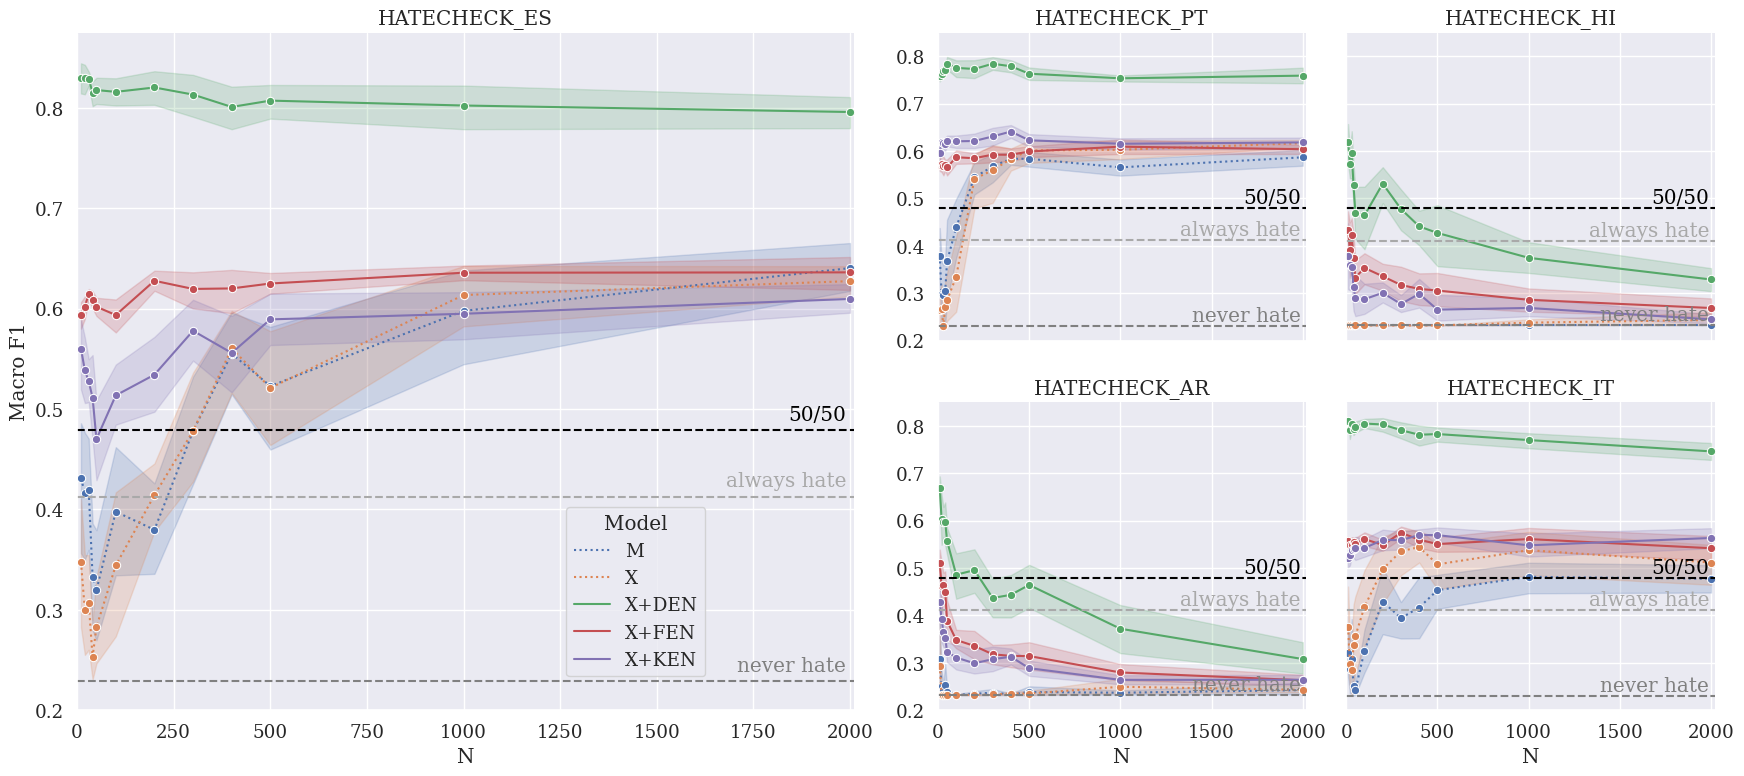

In [828]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["ken", "_0"]
RESULTS_ON_FULL_DATA = True

# set up plot layout
fig = plt.figure(figsize=(16, 8)) 
gs_full = GridSpec(1, 2, width_ratios=[1, 1]) 
gs_l =  gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_full[0])
gs_r =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_full[1])

# iterate through cells in plot grid

# left side

for target_testset, cell in zip(["hatecheck_es"], [c for c in gs_l]):
    f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010), legend=True, legend_xy=(0.63,0.05), yaxis_labels=True, baseline_label=1990)

# right side
for target_testset, cell in zip(["hatecheck_pt", "hatecheck_hi", "hatecheck_ar", "hatecheck_it"], [c for c in gs_r]):
    if cell==gs_r[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.85), legend=False, xaxis_labels=False, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.85), legend=False, xaxis_labels=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)
    if cell==gs_r[2]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.85), legend=False, xaxis_labels=True, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[3]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.85), legend=False, xaxis_labels=True, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_hatecheck_2000.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

### TABLE 2: Macro F1 on HateCheck

In [852]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = ["hatecheck_es", "hatecheck_pt", "hatecheck_hi", "hatecheck_ar", "hatecheck_it"]
TRAIN_SIZES = [20,200,2000]

generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES)

M & 0.42 & 0.38 & 0.64 & 0.30 & 0.54 & 0.59 & 0.23 & 0.23 & 0.23 & 0.25 & 0.23 & 0.24 & 0.29 & 0.43 & 0.48 \\
X & 0.30 & 0.41 & 0.63 & 0.27 & 0.54 & 0.62 & 0.23 & 0.23 & 0.24 & 0.23 & 0.23 & 0.24 & 0.30 & 0.50 & 0.51 \\
X+DEN & 0.83 & 0.82 & 0.80 & 0.76 & 0.77 & 0.76 & 0.57 & 0.53 & 0.33 & 0.60 & 0.50 & 0.31 & 0.79 & 0.80 & 0.75 \\
X+FEN & 0.60 & 0.63 & 0.64 & 0.57 & 0.58 & 0.60 & 0.39 & 0.34 & 0.27 & 0.46 & 0.34 & 0.26 & 0.55 & 0.55 & 0.54 \\
X+KEN & 0.54 & 0.53 & 0.61 & 0.62 & 0.62 & 0.62 & 0.36 & 0.30 & 0.24 & 0.39 & 0.30 & 0.26 & 0.53 & 0.56 & 0.56 \\


### APPENDIX: Macro F1 on HateCheck

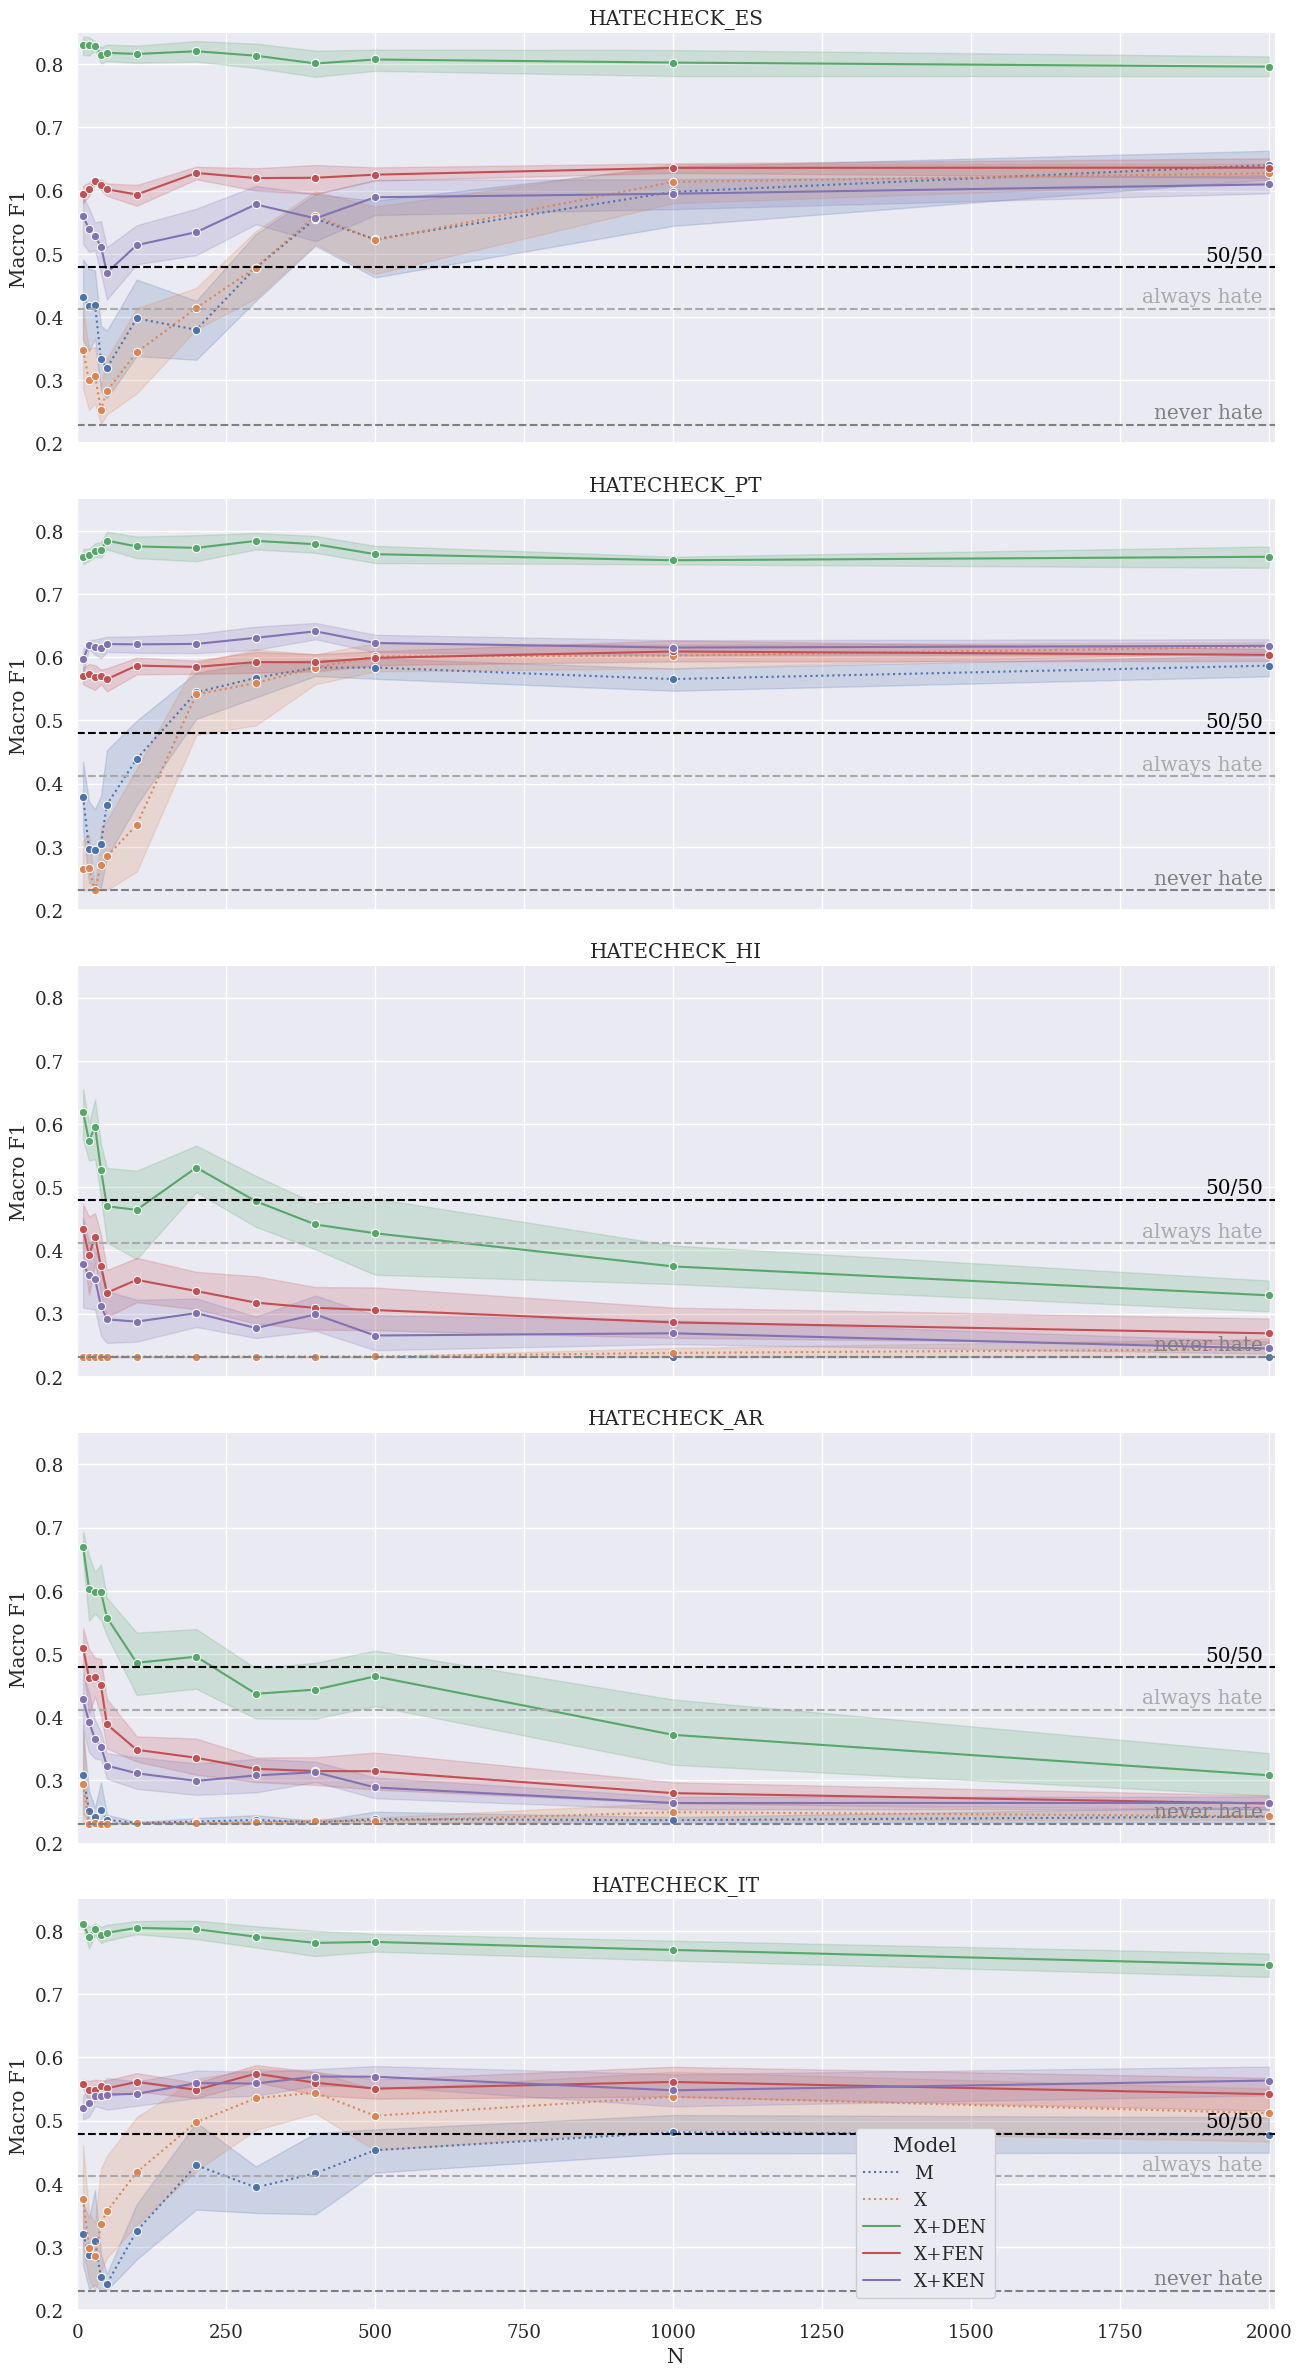

In [882]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(12, 24))
gs_full = GridSpec(5, 1)

# iterate through cells in plot grid
for target_testset, cell in zip(["hatecheck_es", "hatecheck_pt", "hatecheck_hi", "hatecheck_ar", "hatecheck_it"], [c for c in gs_full]):
    if cell!=gs_full[-1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.2,0.85), legend=False, xaxis_labels=False,
            yaxis_labels=True, baseline_label=1990)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.2,0.85), legend=True, legend_xy=(0.65,0.03),
            yaxis_labels=True, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_hatecheck_fullpage.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [886]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = ["hatecheck_es", "hatecheck_pt", "hatecheck_hi", "hatecheck_ar", "hatecheck_it"]
TRAIN_SIZES = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

for testset in TESTSETS:
    print(testset)
    generate_latex_table(MODELS, [testset], TRAIN_SIZES)
    print()

hatecheck_es
M & 0.43 & 0.42 & 0.42 & 0.33 & 0.32 & 0.40 & 0.38 & 0.48 & 0.56 & 0.52 & 0.60 & 0.64 \\
X & 0.35 & 0.30 & 0.31 & 0.25 & 0.28 & 0.34 & 0.41 & 0.48 & 0.56 & 0.52 & 0.61 & 0.63 \\
X+DEN & 0.83 & 0.83 & 0.83 & 0.82 & 0.82 & 0.82 & 0.82 & 0.81 & 0.80 & 0.81 & 0.80 & 0.80 \\
X+FEN & 0.59 & 0.60 & 0.61 & 0.61 & 0.60 & 0.59 & 0.63 & 0.62 & 0.62 & 0.63 & 0.64 & 0.64 \\
X+KEN & 0.56 & 0.54 & 0.53 & 0.51 & 0.47 & 0.51 & 0.53 & 0.58 & 0.56 & 0.59 & 0.59 & 0.61 \\

hatecheck_pt
M & 0.38 & 0.30 & 0.30 & 0.31 & 0.37 & 0.44 & 0.54 & 0.57 & 0.58 & 0.58 & 0.57 & 0.59 \\
X & 0.27 & 0.27 & 0.23 & 0.27 & 0.28 & 0.33 & 0.54 & 0.56 & 0.58 & 0.60 & 0.60 & 0.62 \\
X+DEN & 0.76 & 0.76 & 0.77 & 0.77 & 0.78 & 0.78 & 0.77 & 0.78 & 0.78 & 0.76 & 0.75 & 0.76 \\
X+FEN & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.59 & 0.58 & 0.59 & 0.59 & 0.60 & 0.61 & 0.60 \\
X+KEN & 0.60 & 0.62 & 0.62 & 0.62 & 0.62 & 0.62 & 0.62 & 0.63 & 0.64 & 0.62 & 0.62 & 0.62 \\

hatecheck_hi
M & 0.23 & 0.23 & 0.23 & 0.23 & 0.23 & 0.23 &

## HateCheck Deep Dive

In [ ]:
# load hatecheck cases

hatecheck_dict = dict()

for hc in sorted(os.listdir("../0_data/hatecheck/")):
    if "ipynb" not in hc:
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [10]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_ar
hatecheck_es
hatecheck_hi
hatecheck_it
hatecheck_pt


In [255]:
mhc_metrics_dict = copy.deepcopy(results_dict)

for testset in [k for k in mhc_metrics_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in mhc_metrics_dict[testset]:
        print(" ", model)
        for size in mhc_metrics_dict[testset][model]:
            for random_state in mhc_metrics_dict[testset][model][size]:
                mhc_metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                                metrics_dict[testset][model][size][random_state]["prediction"],
                                                                                average="macro")

bas19_es_test_2000
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
for19_pt_test_2000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
has21_hi_test_2000
  hibert_hi_has21_hi
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_ar
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_hi
  hibert_hi_has21_hi
  xlmt_dyn21_en_20000
hatecheck_it
  umberto_it_san20_it
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
ous19_ar_test_1000
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000

### HateCheck Eval: Performance by Functional Test

In [9]:
# load hatecheck cases

hatecheck_dict = dict()

for hc in sorted(os.listdir("../0_data/hatecheck/")):
    if "ipynb" not in hc:
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [10]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_ar
hatecheck_es
hatecheck_hi
hatecheck_it
hatecheck_pt


In [11]:
%%time

# create df with accuracy by functional test for each hatecheck and model and train size and random state

hatecheck_func_df = pd.DataFrame(columns=["testset", "functionality", "model", "train_size", "random_state", "accuracy"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for func in pd.unique(results_dict[testset][model][size][random_state].functionality):
                    temp_df = results_dict[testset][model][size][random_state]
                    acc = np.mean(temp_df[temp_df.functionality==func].label==temp_df[temp_df.functionality==func].prediction)
                    hatecheck_func_df.loc[len(hatecheck_func_df)+1] = [testset, func, model, int(size), random_state, acc]    

hatecheck_ar
   xlmt_fou18_en_20000
   xlmt_dyn21_en_0
   xlmt_ken20_en_20000
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_ken20_en_20000
   xlmt_dyn21_en_0
   xlmt_fou18_en_20000
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 2min 33s, sys: 4.16 s, total: 2min 37s
Wall time: 2min 37s


In [12]:
def generate_func_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.functionality)
    table = table.groupby(["functionality", "train_size"]).agg({"accuracy": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="functionality", columns="train_size", values="accuracy").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = 1).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [210]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "umberto" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_func_table(hatecheck_func_df, lang, model)

****************************** 
IT
umberto_it_san20_it


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.47,0.21,0.24,0.13,0.04,0.15,0.28,0.15,0.19,0.21,0.17,0.23
derog_neg_attrib_h,0.43,0.19,0.25,0.10,0.00,0.11,0.35,0.24,0.29,0.35,0.37,0.31
derog_dehum_h,0.42,0.18,0.21,0.10,0.01,0.07,0.30,0.21,0.28,0.33,0.40,0.36
derog_impl_h,0.41,0.19,0.24,0.10,0.01,0.04,0.16,0.11,0.15,0.17,0.21,0.20
threat_dir_h,0.39,0.15,0.19,0.10,0.00,0.04,0.24,0.16,0.20,0.26,0.40,0.45
threat_norm_h,0.40,0.18,0.24,0.10,0.01,0.08,0.36,0.27,0.31,0.40,0.50,0.53
slur_h,0.40,0.17,0.18,0.11,0.01,0.12,0.30,0.21,0.25,0.28,0.32,0.32
profanity_h,0.42,0.20,0.27,0.11,0.02,0.24,0.55,0.45,0.50,0.60,0.63,0.64
profanity_nh,0.58,0.82,0.73,0.90,0.97,0.83,0.60,0.77,0.75,0.70,0.64,0.59


### HateCheck Eval: Performance by Targeted Group

In [14]:
%%time

# create df with accuracy by target group for each hatecheck and model and train size and random state

hatecheck_target_df = pd.DataFrame(columns=["testset", "target_ident", "model", "train_size", "random_state", "macro_f1"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for tg in pd.unique(results_dict[testset][model][size][random_state].target_ident)[:-1]:
                    temp_df = results_dict[testset][model][size][random_state]
                    macro_f1 = f1_score(temp_df[temp_df.target_ident==tg].label, temp_df[temp_df.target_ident==tg].prediction, average="macro", zero_division = 0)
                    hatecheck_target_df.loc[len(hatecheck_target_df)+1] = [testset, tg, model, int(size), random_state, macro_f1]    

hatecheck_ar
   xlmt_fou18_en_20000
   xlmt_dyn21_en_0
   xlmt_ken20_en_20000
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_ken20_en_20000
   xlmt_dyn21_en_0
   xlmt_fou18_en_20000
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 30.7 s, sys: 201 ms, total: 30.9 s
Wall time: 31 s


In [15]:
def generate_target_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.target_ident)
    table = table.groupby(["target_ident", "train_size"]).agg({"macro_f1": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="target_ident", columns="train_size", values="macro_f1").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = None).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [216]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "bertimb" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
bertimbau_pt_for19_pt


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.40,0.27,0.27,0.28,0.35,0.44,0.52,0.55,0.58,0.57,0.55,0.55
black people,0.32,0.26,0.24,0.25,0.34,0.39,0.53,0.55,0.57,0.55,0.53,0.56
gay people,0.38,0.26,0.28,0.29,0.35,0.46,0.49,0.55,0.52,0.52,0.51,0.51
trans people,0.38,0.26,0.26,0.29,0.34,0.43,0.49,0.54,0.56,0.55,0.54,0.56
indigenous people,0.30,0.26,0.22,0.24,0.28,0.30,0.44,0.51,0.52,0.52,0.52,0.52
jews,0.26,0.25,0.20,0.24,0.25,0.28,0.48,0.53,0.54,0.55,0.54,0.58
disabled people,0.34,0.26,0.25,0.26,0.32,0.33,0.44,0.53,0.54,0.53,0.50,0.48


In [217]:
for lang in ["pt"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "20000" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
xlmt_fou18_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.59,0.57,0.58,0.60,0.58,0.57,0.57,0.60,0.57,0.58,0.60,0.60
black people,0.46,0.47,0.47,0.46,0.47,0.50,0.49,0.51,0.50,0.50,0.51,0.51
gay people,0.45,0.46,0.45,0.45,0.46,0.48,0.46,0.50,0.50,0.48,0.49,0.49
trans people,0.52,0.52,0.53,0.51,0.52,0.56,0.56,0.57,0.56,0.58,0.60,0.58
indigenous people,0.53,0.54,0.55,0.55,0.55,0.55,0.57,0.55,0.57,0.57,0.58,0.57
jews,0.49,0.50,0.51,0.49,0.51,0.54,0.54,0.57,0.56,0.57,0.59,0.60
disabled people,0.52,0.53,0.52,0.52,0.52,0.54,0.53,0.54,0.55,0.58,0.56,0.56


****************************** 
PT
xlmt_ken20_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.47,0.53,0.50,0.51,0.51,0.53,0.55,0.56,0.60,0.58,0.56,0.57
black people,0.64,0.65,0.66,0.64,0.66,0.60,0.57,0.57,0.57,0.55,0.52,0.52
gay people,0.61,0.61,0.62,0.61,0.62,0.61,0.59,0.59,0.57,0.57,0.55,0.50
trans people,0.45,0.52,0.50,0.51,0.51,0.54,0.55,0.57,0.61,0.57,0.56,0.56
indigenous people,0.59,0.63,0.61,0.61,0.62,0.63,0.64,0.64,0.66,0.62,0.60,0.62
jews,0.62,0.64,0.63,0.64,0.63,0.64,0.63,0.64,0.66,0.64,0.62,0.62
disabled people,0.62,0.64,0.63,0.62,0.64,0.61,0.60,0.61,0.62,0.60,0.58,0.58


****************************** 
PT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.76,0.76,0.76,0.76,0.78,0.76,0.75,0.75,0.74,0.72,0.73,0.73
black people,0.74,0.75,0.76,0.74,0.76,0.74,0.74,0.74,0.73,0.71,0.71,0.72
gay people,0.79,0.78,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.72,0.72,0.74
trans people,0.80,0.79,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.74,0.72,0.75
indigenous people,0.75,0.76,0.77,0.77,0.77,0.76,0.74,0.77,0.76,0.73,0.73,0.74
jews,0.79,0.78,0.79,0.78,0.80,0.79,0.77,0.79,0.77,0.76,0.74,0.74
disabled people,0.41,0.44,0.47,0.49,0.56,0.56,0.65,0.67,0.68,0.68,0.69,0.68


## Regression Analysis

### OLS by Testset + Model

In [894]:
def fit_ols(metrics_df, testset, model, plot=False):

    regression_df = metrics_df[metrics_df.selection_strat_category=="random"].copy()
    
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "arabert_ar_ous19_ar": "M", "umberto_it_san20_it": "M", "bertimbau_pt_for19_pt": "M", "hibert_hi_has21_hi": "M"}
    regression_df["model"] = regression_df.model.apply(lambda x: model_map[x])
    
    regression_df = regression_df[regression_df.testset==testset]
    regression_df = regression_df[regression_df.model==model]

    X = regression_df.log_train_size
    Y = regression_df.macro_f1

    ols_model = sm.OLS(Y, sm.add_constant(X))
    results = ols_model.fit(cov_type='HC3')

    #print(results.summary(),"\n")
    
    print("const & b1 & R2 & dbl")
    print(testset[:8], "&",round(results.params[0], 4),"&", round(results.params[1], 4), "&", round(results.rsquared_adj*100,2), "&", round(np.log(2)*results.params[1]*100, 2))
    
    # create plot with OLS results and original data
    if plot:

        f = plt.figure(figsize=(12,8))
        p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = regression_df, estimator="mean", marker="o", ci=95)
        p.plot(regression_df.train_size, results.fittedvalues, "r-", label="OLS")
        #p.plot(regression_df.train_size, Y, ".", label="data")

        p.set_title(f"Test Set: {testset.upper()}: {results_dict[testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
        p.set_xlabel("Number of Training Instances")
        p.set_ylabel("Macro F1")
        p.legend(loc="best")
        sns.despine()
        plt.show()
    
    return None

for testset in ["bas19_es_test_2000", "for19_pt_test_2000", "ous19_ar_test_1000", "san20_it_test_2000","has21_hi_test_2000"]:
#for testset in ["hatecheck_es", "hatecheck_pt", "hatecheck_ar", "hatecheck_it", "hatecheck_hi"]:
    for model in ["X+KEN"]:
        print("==="*20)
        print("TESTSET:",testset.upper())
        print("MODEL:\t",model.upper())
        print("==="*20,"\n")
        fit_ols(metrics_df, testset, model, plot=False)
        print()

TESTSET: BAS19_ES_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
bas19_es & 0.5011 & 0.0381 & 93.59 & 2.64

TESTSET: FOR19_PT_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
for19_pt & 0.5797 & 0.0182 & 72.81 & 1.26

TESTSET: OUS19_AR_TEST_1000
MODEL:	 X+KEN

const & b1 & R2 & dbl
ous19_ar & 0.5545 & 0.0195 & 40.66 & 1.35

TESTSET: SAN20_IT_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
san20_it & 0.5712 & 0.026 & 82.84 & 1.8

TESTSET: HAS21_HI_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
has21_hi & 0.4444 & 0.0198 & 42.5 & 1.37

